In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.3 MB/s eta 0:00:0000:01


In [2]:
# Cell 1: Imports and Setup
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from scipy.stats import kendalltau
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, 
                           confusion_matrix, roc_curve, auc, precision_recall_curve)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pywt
from torch_geometric.data import Data
from torch_geometric.nn import GINConv, global_mean_pool
import random

# Set random seeds for reproducibility
# def set_seed(seed=42):
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     np.random.seed(seed)
#     random.seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# set_seed(42)

In [3]:
# Cell 2: Data Loading and Preprocessing
def parse_multivariate_ts_fixed(file_path):
    time_series_list = []
    labels = []
    with open(file_path, "r") as file:
        for line in file:
            if line.startswith("#") or line.startswith("@"):
                continue
            parts = line.strip().split(":")
            series = [list(map(float, ts.split(","))) for ts in parts[:-1]]
            label = parts[-1].strip()
            time_series_list.append(np.array(series))
            labels.append(label)
    return np.array(time_series_list, dtype=object), np.array(labels)

# Load data
train_file_path = "/kaggle/input/basicmotions/BasicMotions_TRAIN.ts"
test_file_path = "/kaggle/input/basicmotions/BasicMotions_TEST.ts"
train_data, train_labels = parse_multivariate_ts_fixed(train_file_path)
test_data, test_labels = parse_multivariate_ts_fixed(test_file_path)

# Convert to float32
train_data = np.array(train_data, dtype=np.float32)
test_data = np.array(test_data, dtype=np.float32)

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print("\nClass distribution:")
print("Train:", dict(zip(*np.unique(train_labels, return_counts=True))))
print("Test:", dict(zip(*np.unique(test_labels, return_counts=True))))

Train data shape: (40, 6, 100)
Test data shape: (40, 6, 100)

Class distribution:
Train: {'Badminton': 10, 'Running': 10, 'Standing': 10, 'Walking': 10}
Test: {'Badminton': 10, 'Running': 10, 'Standing': 10, 'Walking': 10}


In [4]:
def augment_time_series(data, labels, noise_level=0.05, warp_factor=0.1):
    """
    Augments time series data with:
    - Gaussian noise
    - Time warping
    """
    augmented_data = []
    augmented_labels = []
    
    for sample, label in zip(data, labels):
        # Original sample
        augmented_data.append(sample)
        augmented_labels.append(label)
        
        # 1. Add Gaussian noise
        noisy_sample = sample + np.random.normal(0, noise_level, sample.shape)
        augmented_data.append(noisy_sample)
        augmented_labels.append(label)
        
        # 2. Time warping
        warped_sample = np.zeros_like(sample)
        for i in range(sample.shape[0]):  # For each sensor
            x_original = np.linspace(0, 1, sample.shape[1])
            x_warped = np.clip(x_original + np.random.normal(0, warp_factor, x_original.shape), 0, 1)
            warped_sample[i] = np.interp(x_original, x_warped, sample[i])
        augmented_data.append(warped_sample)
        augmented_labels.append(label)
    
    return np.array(augmented_data), np.array(augmented_labels)

# Apply augmentation to training data only
train_data, train_labels = augment_time_series(train_data, train_labels)
test_data, test_labels = augment_time_series(test_data, test_labels)
print(f"Augmented train data shape: {train_data.shape}")
print("Augmented class distribution:", dict(zip(*np.unique(train_labels, return_counts=True))))

Augmented train data shape: (120, 6, 100)
Augmented class distribution: {'Badminton': 30, 'Running': 30, 'Standing': 30, 'Walking': 30}


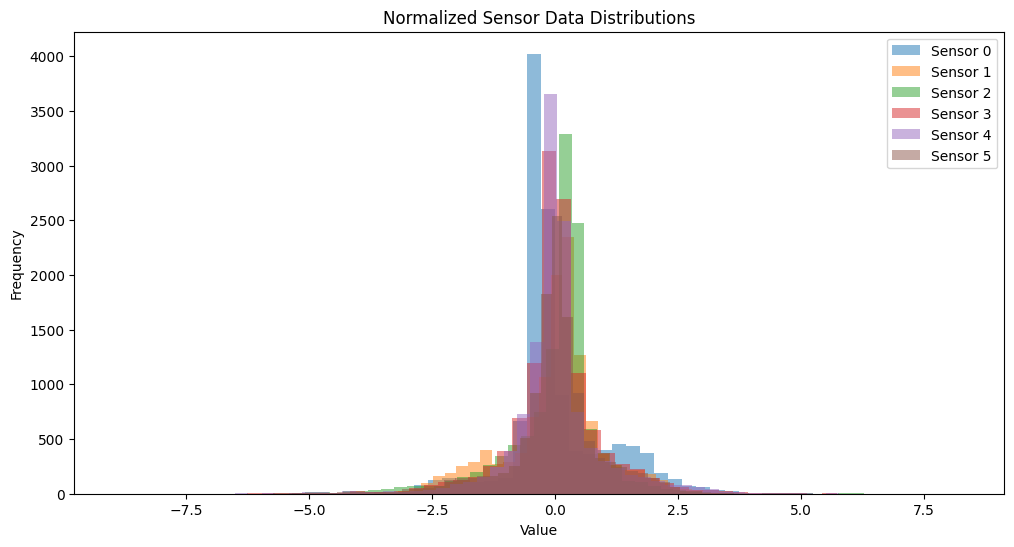

In [5]:
# Cell 3: Data Normalization and Visualization
# Normalize each feature separately
scalers = [StandardScaler() for _ in range(train_data.shape[1])]

for i in range(train_data.shape[1]):
    train_data[:, i, :] = scalers[i].fit_transform(train_data[:, i, :])
    test_data[:, i, :] = scalers[i].transform(test_data[:, i, :])

# Plot normalized feature distributions
plt.figure(figsize=(12, 6))
for i in range(train_data.shape[1]):
    plt.hist(train_data[:, i, :].flatten(), bins=50, alpha=0.5, label=f'Sensor {i}')
plt.title("Normalized Sensor Data Distributions")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("SaiChiranthan-221AI035-normalizedgraph.jpg")
plt.show()

In [6]:
# Cell 4: Wavelet Transform
wavelet = 'morl'
scales = np.arange(1, 31)

def compute_cwt(data):
    num_samples, num_features, num_timesteps = data.shape
    cwt_output = np.zeros((num_samples, num_features, len(scales), num_timesteps))
    
    for sample_idx in range(num_samples):
        for feature_idx in range(num_features):
            coef, _ = pywt.cwt(data[sample_idx, feature_idx, :], scales, wavelet)
            cwt_output[sample_idx, feature_idx, :, :] = coef
    return cwt_output

# Apply CWT
train_cwt = compute_cwt(train_data)
test_cwt = compute_cwt(test_data)

print(f"CWT output shape: {train_cwt.shape}")

CWT output shape: (120, 6, 30, 100)


In [7]:
# Cell 5: Attention Mechanism
class SelfAttention(nn.Module):
    def __init__(self, dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        self.scale = torch.sqrt(torch.tensor(dim, dtype=torch.float32))

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        attention_weights = torch.softmax(attention_scores, dim=-1)
        attention_output = torch.matmul(attention_weights, V)
        return attention_output

# Convert to tensors and apply attention
train_cwt_tensor = torch.tensor(train_cwt, dtype=torch.float32)
test_cwt_tensor = torch.tensor(test_cwt, dtype=torch.float32)

num_samples, num_features, num_scales, num_timesteps = train_cwt_tensor.shape
train_flattened = train_cwt_tensor.view(num_samples, num_features, -1)

self_attention_layer = SelfAttention(dim=num_scales * num_timesteps)
train_attention_output = torch.zeros_like(train_flattened)

for i in range(num_features):
    train_attention_output[:, i, :] = self_attention_layer(train_flattened[:, i, :])

print(f"Attention output shape: {train_attention_output.shape}")

Attention output shape: torch.Size([120, 6, 3000])


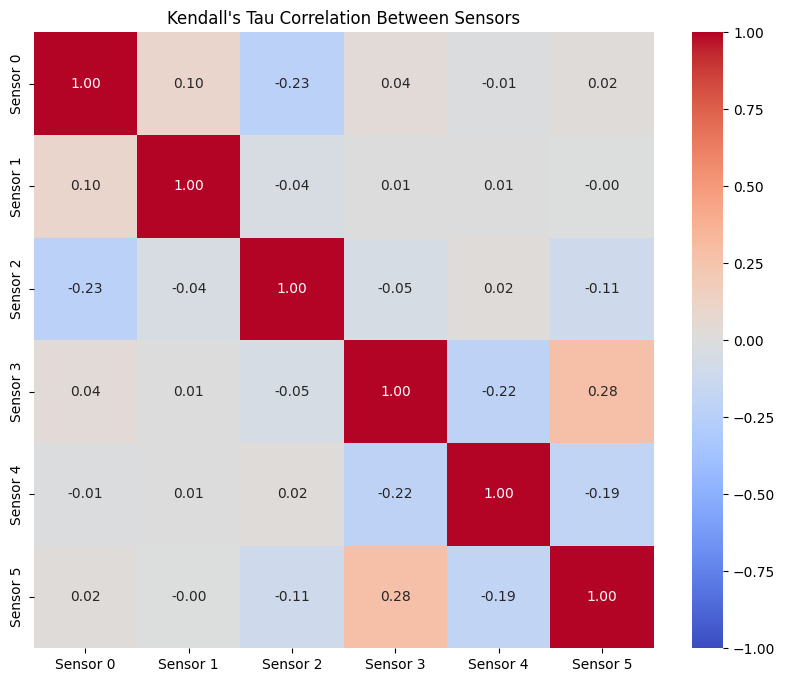

In [8]:
# Cell 6: Kendall Correlation and Graph Construction
def compute_kendall_correlation(data):
    num_features = data.shape[1]
    correlation_matrix = np.zeros((num_features, num_features))
    for i in range(num_features):
        for j in range(num_features):
            if i != j:
                tau, _ = kendalltau(data[:, i, :].flatten(), data[:, j, :].flatten())
                correlation_matrix[i, j] = tau
            else:
                correlation_matrix[i, j] = 1
    return correlation_matrix

kendall_corr = compute_kendall_correlation(train_data)

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(kendall_corr, annot=True, cmap="coolwarm", fmt=".2f",
            xticklabels=[f"Sensor {i}" for i in range(6)],
            yticklabels=[f"Sensor {i}" for i in range(6)],
            vmin=-1, vmax=1)
plt.title("Kendall's Tau Correlation Between Sensors")
plt.savefig("SaiChiranthan-221AI035-kendallheatmap.jpg")
plt.show()

# Build graph
edge_index = []
edge_attr = []
for i in range(6):
    for j in range(6):
        if i != j:
            edge_index.append([i, j])
            edge_attr.append(kendall_corr[i, j])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr, dtype=torch.float32)

In [9]:
# Cell 7: GIN Model Definition
class ImprovedGIN(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_classes):
        super().__init__()
        
        # Enhanced GIN layers with batch norm and dropout
        self.conv1 = GINConv(nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        ))
        
        self.conv2 = GINConv(nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        ))
        
        # Deeper classifier
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim//2, num_classes)
        )
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        
        # Global pooling
        batch = torch.arange(x.size(0), device=x.device)
        x = global_mean_pool(x, batch)
        
        # Final classification
        x = self.fc(x)
        return x

# Initialize improved model
device = torch.device("cpu")
model = ImprovedGIN(in_dim=6, hidden_dim=64, num_classes=4)  # Increased hidden dim
model = model.to(device)

# Print model parameters
def print_model_parameters(model):
    print("\nDetailed Model Parameters:")
    print("="*80)
    for name, param in model.named_parameters():
        print(f"\nLayer: {name}")
        print(f"Shape: {param.shape}")
        print(f"Requires Grad: {param.requires_grad}")
        print(f"Data Type: {param.dtype}")
        print("First 5 values:" if len(param.shape) > 0 else "Value:", param.data.flatten()[:5])
        print(f"Mean: {param.data.mean().item():.6f}")
        print(f"Std: {param.data.std().item():.6f}")
        print(f"Min: {param.data.min().item():.6f}")
        print(f"Max: {param.data.max().item():.6f}")
        if len(param.shape) > 1:
            print(f"L2 Norm: {torch.norm(param.data, p=2).item():.6f}")
    
    print("\nBatch Normalization Layers:")
    print("="*80)
    for name, module in model.named_modules():
        if isinstance(module, nn.BatchNorm1d):
            print(f"\nLayer: {name}")
            print(f"Running Mean: {module.running_mean[:5].tolist()}...")
            print(f"Running Var: {module.running_var[:5].tolist()}...")
            print(f"Num Features: {module.num_features}")
            print(f"Eps: {module.eps}")
            print(f"Momentum: {module.momentum}")
            print(f"Affine: {module.affine}")
            print(f"Track Running Stats: {module.track_running_stats}")
    
    print("\nModel Summary:")
    print("="*80)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Parameters: {total_params}")
    print(f"Trainable Parameters: {trainable_params}")
    print(f"Non-trainable Parameters: {total_params - trainable_params}")
    print("="*80)

print_model_parameters(model)


Detailed Model Parameters:

Layer: conv1.nn.0.weight
Shape: torch.Size([64, 6])
Requires Grad: True
Data Type: torch.float32
First 5 values: tensor([ 0.2727,  0.2337, -0.0105, -0.2403,  0.3704])
Mean: 0.017306
Std: 0.233879
Min: -0.407706
Max: 0.404414
L2 Norm: 4.589656

Layer: conv1.nn.0.bias
Shape: torch.Size([64])
Requires Grad: True
Data Type: torch.float32
First 5 values: tensor([-0.1320, -0.1931, -0.2446, -0.3362,  0.1264])
Mean: -0.060658
Std: 0.227261
Min: -0.400557
Max: 0.384306

Layer: conv1.nn.1.weight
Shape: torch.Size([64])
Requires Grad: True
Data Type: torch.float32
First 5 values: tensor([1., 1., 1., 1., 1.])
Mean: 1.000000
Std: 0.000000
Min: 1.000000
Max: 1.000000

Layer: conv1.nn.1.bias
Shape: torch.Size([64])
Requires Grad: True
Data Type: torch.float32
First 5 values: tensor([0., 0., 0., 0., 0.])
Mean: 0.000000
Std: 0.000000
Min: 0.000000
Max: 0.000000

Layer: conv1.nn.4.weight
Shape: torch.Size([64, 64])
Requires Grad: True
Data Type: torch.float32
First 5 values:

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [10/200], Loss: 1.3331, Accuracy: 0.3583
Epoch [20/200], Loss: 1.2594, Accuracy: 0.4417
Epoch [30/200], Loss: 1.1833, Accuracy: 0.4417
Epoch [40/200], Loss: 1.1020, Accuracy: 0.4750
Epoch [50/200], Loss: 1.0301, Accuracy: 0.4833
Epoch [60/200], Loss: 0.9829, Accuracy: 0.5167
Epoch [70/200], Loss: 0.9223, Accuracy: 0.5667
Epoch [80/200], Loss: 0.8472, Accuracy: 0.6167
Epoch [90/200], Loss: 0.8121, Accuracy: 0.6167
Epoch [100/200], Loss: 0.7247, Accuracy: 0.6500
Epoch [110/200], Loss: 0.6520, Accuracy: 0.7167
Epoch [120/200], Loss: 0.5957, Accuracy: 0.7250
Epoch [130/200], Loss: 0.5198, Accuracy: 0.8083
Epoch [140/200], Loss: 0.5295, Accuracy: 0.7333
Epoch [150/200], Loss: 0.4612, Accuracy: 0.8000
Epoch [160/200], Loss: 0.4237, Accuracy: 0.8500
Epoch [170/200], Loss: 0.4265, Accuracy: 0.8000
Epoch [180/200], Loss: 0.4188, Accuracy: 0.8083
Epoch [190/200], Loss: 0.4192, Accuracy: 0.8167
Epoch [200/200], Loss: 0.4112, Accuracy: 0.8083

Training completed in 1.18 seconds


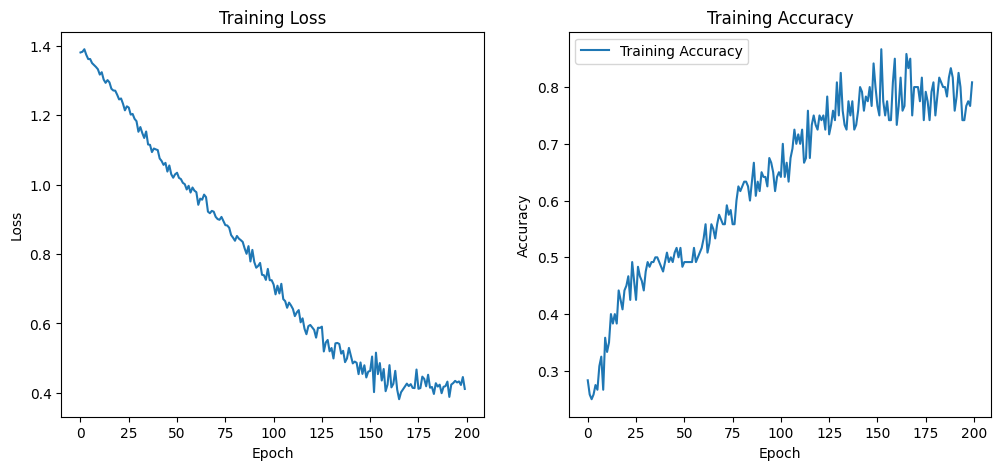

In [10]:
from torch.optim import AdamW

# Cell 8: Training Setup and Execution
# Prepare graph data
graph_data = Data(
    x=train_attention_output.mean(dim=-1).clone().detach(),
    edge_index=edge_index,
    edge_attr=edge_attr
)

# Prepare labels
label_mapping = {'Badminton': 0, 'Running': 1, 'Standing': 2, 'Walking': 3}
train_labels_idx = torch.tensor([label_mapping[label] for label in train_labels], dtype=torch.long)
test_labels_idx = torch.tensor([label_mapping[label] for label in test_labels], dtype=torch.long)

# Move to CPU
model = model.to(device)
graph_data = graph_data.to(device)
train_labels_idx = train_labels_idx.to(device)

# Enhanced optimizer with weight decay
optimizer = AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

train_losses = []  # Initialize list for storing training losses
train_accuracies = []  # Initialize list for storing training accuracies

# Early stopping
best_loss = float('inf')
patience = 15
patience_counter = 0
num_epochs=200
start_time = time.time()
# Training loop modifications
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    output = model(graph_data)
    loss = loss_fn(output, train_labels_idx)
    loss.backward()
    
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
    optimizer.step()
    scheduler.step(loss)
    
    # Calculate accuracy
    _, predicted = torch.max(output.data, 1)
    accuracy = (predicted == train_labels_idx).float().mean()
    
    train_losses.append(loss.item())
    train_accuracies.append(accuracy.item())
    
    # # Early stopping check
    # if loss.item() < best_loss:
    #     best_loss = loss.item()
    #     patience_counter = 0
    #     # Save best model
    #     torch.save(model.state_dict(), "SaiChiranthan-221AI035-best_model.pth")
    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print(f"Early stopping at epoch {epoch+1}")
    #         break
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")
training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds")

# Save training metrics
min_length = min(len(train_losses), len(train_accuracies), num_epochs)
metrics_df = pd.DataFrame({
    'Epoch': range(1, min_length + 1),
    'Loss': train_losses[:min_length],
    'Accuracy': train_accuracies[:min_length]
})

metrics_df.to_excel("SaiChiranthan-221AI035-trainingmetrics.xlsx", index=False)

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.savefig("SaiChiranthan-221AI035-trainingcurves.jpg")
plt.show()

# Save model
torch.save(model.state_dict(), "SaiChiranthan-221AI035-model.pth")

<ipython-input-11-a606d04cff0e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("SaiChiranthan-221AI035-model.pth"))


Average testing time per sample: 0.0010 seconds

Model Accuracy: 0.9000

Classification Report:
               precision    recall  f1-score   support

   Badminton       1.00      0.90      0.95        30
     Running       0.91      1.00      0.95        30
    Standing       0.78      0.97      0.87        30
     Walking       0.96      0.73      0.83        30

    accuracy                           0.90       120
   macro avg       0.91      0.90      0.90       120
weighted avg       0.91      0.90      0.90       120



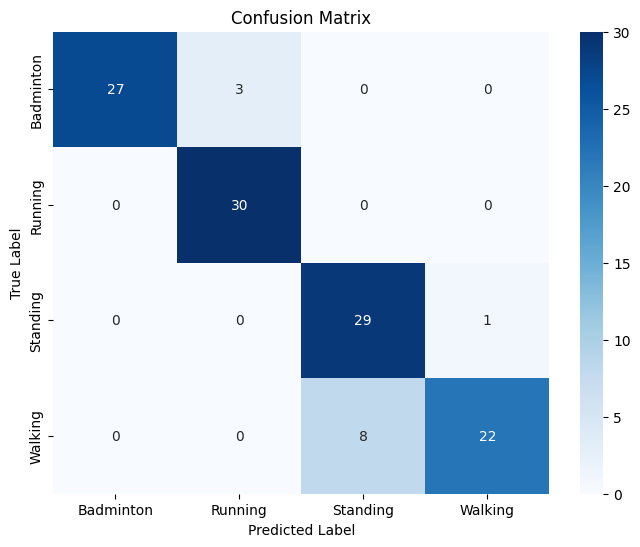

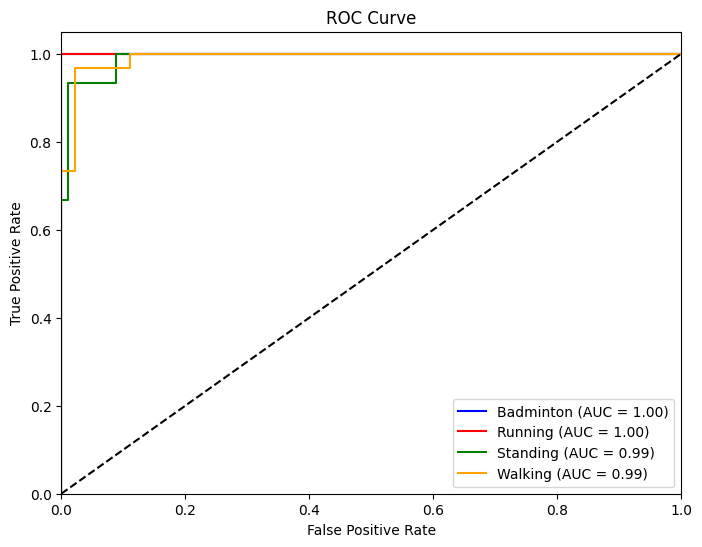

Number of misclassified samples: 12/120


In [11]:
# Cell 9: Evaluation and Testing
# Load model (for demonstration - normally would be in separate file)
model.load_state_dict(torch.load("SaiChiranthan-221AI035-model.pth"))
model.eval()

# Evaluation
test_times = []
all_predictions = []
test_probs = []

with torch.no_grad():
    for i in range(len(test_data)):
        start_time = time.time()
        output = model(graph_data)
        test_times.append(time.time() - start_time)
        
        # Get prediction for this sample
        _, predicted = torch.max(output[i].unsqueeze(0), 1)
        all_predictions.append(predicted.item())
        test_probs.append(F.softmax(output[i], dim=0).numpy())

avg_test_time = sum(test_times) / len(test_times)
print(f"Average testing time per sample: {avg_test_time:.4f} seconds")

# Save testing times
pd.DataFrame({'Test Times': test_times + [avg_test_time]}).to_excel("SaiChiranthan-221AI035-testingtime.xlsx")

# Convert predictions
test_predictions = np.array(all_predictions)
inv_label_mapping = {v: k for k, v in label_mapping.items()}

# Evaluation metrics
accuracy = accuracy_score(test_labels_idx, test_predictions)
report = classification_report(test_labels_idx, test_predictions, 
                             target_names=label_mapping.keys(),
                             zero_division=0)
conf_matrix = confusion_matrix(test_labels_idx, test_predictions)

print(f"\nModel Accuracy: {accuracy:.4f}\n")
print("Classification Report:\n", report)

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_mapping.keys(),
            yticklabels=label_mapping.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("SaiChiranthan-221AI035-confusionmatrix.jpg")
plt.show()

# ROC Curve
y_test = label_binarize(test_labels_idx, classes=[0, 1, 2, 3])
y_score = np.array(test_probs)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange']
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'{list(label_mapping.keys())[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig("SaiChiranthan-221AI035-roccurve.jpg")
plt.show()

# Save predictions
predictions_df = pd.DataFrame({
    'Actual': test_labels,
    'Predicted': [inv_label_mapping[p] for p in test_predictions],
    'Correct': [test_labels[i] == inv_label_mapping[test_predictions[i]] for i in range(len(test_predictions))]
})
predictions_df.to_excel("SaiChiranthan-221AI035-predictions.xlsx", index=False)

# Print misclassified count
misclassified = len(predictions_df) - predictions_df['Correct'].sum()
print(f"Number of misclassified samples: {misclassified}/{len(predictions_df)}")

In [12]:
# Cell 1: Generate All Output Files
import os
import zipfile
from datetime import datetime

# Create timestamp for unique filenames
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# List of all files to include in the zip
output_files = [
    "SaiChiranthan-221AI035-normalizedgraph.jpg",
    "SaiChiranthan-221AI035-kendallheatmap.jpg",
    "SaiChiranthan-221AI035-trainingmetrics.xlsx",
    "SaiChiranthan-221AI035-trainingcurves.jpg",
    "SaiChiranthan-221AI035-model.pth",
    "SaiChiranthan-221AI035-testingtime.xlsx",
    "SaiChiranthan-221AI035-confusionmatrix.jpg",
    "SaiChiranthan-221AI035-roccurve.jpg",
    "SaiChiranthan-221AI035-predictions.xlsx"
]

# Create zip archive
zip_filename = f"/kaggle/working/SaiChiranthan_221AI035_{timestamp}.zip"
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for file in output_files:
        if os.path.exists(file):
            zipf.write(file)
            print(f"Added {file} to archive")
        else:
            print(f"Warning: {file} not found")

print(f"\nAll files zipped successfully to: {zip_filename}")
print(f"Archive contents:")
with zipfile.ZipFile(zip_filename, 'r') as zipf:
    for file in zipf.namelist():
        print(f"- {file}")

Added SaiChiranthan-221AI035-normalizedgraph.jpg to archive
Added SaiChiranthan-221AI035-kendallheatmap.jpg to archive
Added SaiChiranthan-221AI035-trainingmetrics.xlsx to archive
Added SaiChiranthan-221AI035-trainingcurves.jpg to archive
Added SaiChiranthan-221AI035-model.pth to archive
Added SaiChiranthan-221AI035-testingtime.xlsx to archive
Added SaiChiranthan-221AI035-confusionmatrix.jpg to archive
Added SaiChiranthan-221AI035-roccurve.jpg to archive
Added SaiChiranthan-221AI035-predictions.xlsx to archive

All files zipped successfully to: /kaggle/working/SaiChiranthan_221AI035_20250402_062807.zip
Archive contents:
- SaiChiranthan-221AI035-normalizedgraph.jpg
- SaiChiranthan-221AI035-kendallheatmap.jpg
- SaiChiranthan-221AI035-trainingmetrics.xlsx
- SaiChiranthan-221AI035-trainingcurves.jpg
- SaiChiranthan-221AI035-model.pth
- SaiChiranthan-221AI035-testingtime.xlsx
- SaiChiranthan-221AI035-confusionmatrix.jpg
- SaiChiranthan-221AI035-roccurve.jpg
- SaiChiranthan-221AI035-predicti